---
title: "Association testing"
author:
    - name: Conor O'Hare
    - name: Samuele Soraggi
      orcid: 0000-0002-1159-5535
      email: samuele@birc.au.dk
    - name: Alba Refoyo Martinez
      orcid: 0000-0002-3674-4007
      email: alba.martinez@sund.ku.dk   
---


---
format:
  html:
   theme: default
   number-sections: true
   code-fold: false
   self-contained: false
   toc: true
   highlight-style: pygments
  ipynb:
    toc: true
    number-sections: false
bibliography: references/references_5.bib
---

::: {.callout-note title="Important notes for this notebook" icon=false}

After QC and calculation of MDS components, the data is ready for subsequent association tests. The appropriate statistical test can be selected depending on the expected genetic model of the trait or disease of interest and the nature of the phenotypic trait studied. In this tutorial, we provide scripts for various types of association that are suitable for binary traits (e.g., alcohol-dependent patients vs. healthy controls) or quantitative traits (e.g., the number of alcoholic beverages consumed per week).

## Learning outcomes

- **Discuss** different types of association tests
- **Identify** the suitable association test for your data

## How to make this notebook work

* In this notebook, we will use both `R` and `bash command line` programming languages. Remember to **change the kernel** whenever you transition from one language to the other (`Kernel --> Change Kernel`) indicated by the languages' images. We will first run `Bash` commands.  
  
<img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash kernel
 
:::

### Biometric model

The theory of genetic association is based on the biometrical model. Here's an example (taken from the Biometrical Genetics chapter in @neale2013methodology. The biometric model (first established by Fisher) considers each variant having an additive effect on the value of a trait. Consider for a specific variant its possible genotypes. Each of those has a specific effect on the value of a trait (of mean value m). `aa` contributes with `-d`, AA with `d`. `d` is the measured difference between the homozygotes `AA` and `aa`, with `m` their average effect. `h` is themeasured effect of the heterozygote `Aa`.

![A biometric model showing the two parameters `d` and `h` describing the effect of a variant's genotypes on a trait.](Images/biometric.png){fig-align="center" label="fig-biometricmodel"}
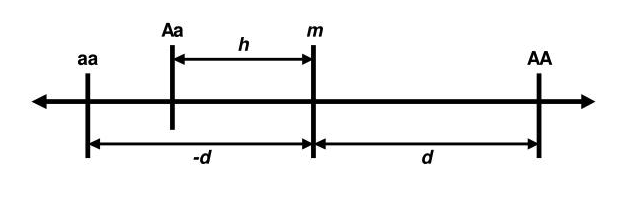

Multiple variants have an additive effect on a trait, meaning `d` and `h` effects will add across variants associated to a trait.

:::{.callout-note title="Example"}

Imagine that we are talking about genes that influence adult stature. Let us assume that the normal range for males is from 4 feet 10 inches (1.47m) to 6 feet 8 inches (2m): that is, about **22 inches (0.56m)**. And let us assume that each somatic chromosome has one gene of roughly equivalent effect. Then, roughly speaking, we are thinking in terms of loci for which the **homozygotes contribute ±d=±1/2 inch (from the midpoint)**, depending on whether they are *AA*, the increasing homozygote, or *aa*, the decreasing homozygote. In reality, although some loci may contribute greater effects than this, others will almost certainly contribute less; thus, we are talking about the kind of model in which any particular polygene is having an effect that would be difficult to detect by the methods of classical genetics. 

:::

Typically in GWAS, we use linear models for when the phenotype is continuous (BMI, height, blood pressure) and logistic models for when the phenotype is binary (whether you have the disease or not). Both of these models should incorporate an additional random effect term $e$, and this is to minimize the effect of covariates. For example, in the above example, the same height genes might affect females in the same way they do males, but the range might be smaller. 

# 6.1 Modelling


### The linear/logistic model

The basic linear regression model is written as:

$$y = G\beta_G + X\beta_X + \epsilon$$

Here, $y$ is the phenotype vector, $G$ is the genotype/dosage matrix (the allele counts) for the current variant, $X$ is the fixed-covariate matrix, and $e$ is the error term subject to least-squares minimization. 

For binary phenotypes, `--logistic` in PLINK fits a logistic or Firth regression model instead, with the same $G\beta_G + X\beta_X$ terms. More details about PLINK's association methods can be found [here](https://www.cog-genomics.org/plink/2.0/assoc).

Within PLINK, the association between SNPs and quantitative outcome measures can be tested with the options `‐‐assoc` and `‐‐linear`. When PLINK detects a quantitative outcome measure (i.e., values other than 1, 2, 0, or NA), the `‐‐assoc` option will automatically treat it as such by performing an asymptotic version of the usual Student's t-test to compare two means. This option does not allow the use of covariates. The `‐‐linear` option in PLINK performs a linear regression analysis with each SNP as a predictor. Similar to the `‐‐logistic` option, the `‐‐linear` option enables the use of covariates and is somewhat slower than the `‐‐assoc` option.

### PLINK in association testing

PLINK offers one degree of freedom (1 df) allelic tests in which the trait value, or the log‐odds of a binary trait, increases or decreases linearly as a function of the number of risk alleles (minor allele *a* against major allele *A*). In addition, non‐additive tests are available:
* the genotypic association test (2 df: *aa* vs *Aa* vs *AA*)
* the dominant gene action test (1 df: *aa* & *Aa* vs *AA*)
* the recessive gene action test, (1 df: aa vs *Aa* & *AA*)

However, non‐additive tests are not widely applied, because the statistical power to detect non‐additivity is low in practice. More complex analyses (e.g., Cox regression analysis) can be performed by using R‐based “plug‐in” functions in PLINK.


### 6.1.1 Analysis with PLINK

<img src="Images/bash.png" alt="Bash" width="40">  We link the data folder to easily access it and create a folder for the output files generated in this notebook. 

In [1]:
ln -sf ../Data
mkdir -p Results/GWAS5

Recall that our dataset contains binary traits: phenotype can take two values 0 or 1. In this tutorial, we will apply both `--assoc`and `--logistic` to our data. A reminder that `--assoc` option does not allow to correct covariates such as principal components (PCs)/MDS components for population stratification, which makes it less suited for association analyses. But it's worth seeing the results to make this clear.

We start with `--assoc`:

In [2]:
plink --bfile Results/GWAS4/HapMap_3_r3_10 --assoc --out Results/GWAS5/assoc_results --silent

Let's have a look at the association output file:

In [8]:
head -5 Results/GWAS5/assoc_results.assoc

 CHR         SNP         BP   A1      F_A      F_U   A2        CHISQ            P           OR 
   1   rs3131972     742584    A   0.1944   0.1455    G       0.9281       0.3354        1.418 
   1   rs3131969     744045    A   0.1759      0.1    G        2.647       0.1037        1.921 
   1   rs1048488     750775    C   0.1981   0.1455    T        1.054       0.3045        1.451 
   1  rs12562034     758311    A  0.06481   0.1182    G        1.863       0.1723       0.5171 


where the columns represent:

* `CHR`	Chromosome code  
* `SNP`	Variant identifier  
* `BP`	Base-pair coordinate  
* `A1`	Allele 1 (usually minor)  
* `F_A`	Allele 1 frequency among cases  
* `F_U`	Allele 1 frequency among controls  
* `A2`	Allele 2  
* `CHISQ`	Allelic test chi-square statistic
* `P`	Allelic test p-value. The p-value indicates the probability that the observed association (or one more extreme) would occur by chance if there is no true association between the SNP and the trait.
* `OR` odds(allele 1 | case) / odds(allele 1 | control)  

Applying `--logistic`, we can now consider principal components as covariates. We will use the MDS components `covar_mds.txt` from the previous tutorial (option `--covar`). We also remove the lines containing NA values in the output, because later will give problems in doing plots.:

In [5]:
# --logistic 
# Note, we use the option --hide-covar to only show the additive results of the SNPs in the output file.
plink --bfile Results/GWAS4/HapMap_3_r3_10 --covar Results/GWAS4/covar_mds.txt --logistic --hide-covar --out Results/GWAS5/logistic_results --silent

# Remove NA values, those might give problems generating plots in later steps.
awk '!/'NA'/' Results/GWAS5/logistic_results.assoc.logistic > Results/GWAS5/logistic_results.assoc_2.logistic

The columns `CHR, SNP, BP, A1, OR, P` have the same meaning as with `--assoc` testing. The new ones are 

- `TEST` the type of test performed. It usually includes "ADD" (additive model) and may also include other genetic models depending on the options specified (e.g., dominant, recessive).
- `NMISS` the number of non-missing observations (individuals) used in the analysis for that particular SNP.
- `STAT` the test t-statistic for the logistic regression test

In [7]:
head -5 Results/GWAS5/logistic_results.assoc.logistic

 CHR         SNP         BP   A1       TEST    NMISS         OR         STAT            P 
   1   rs3131972     742584    A        ADD      109      1.782        1.363       0.1729
   1   rs3131969     744045    A        ADD      109      2.195        1.705      0.08811
   1   rs1048488     750775    C        ADD      108      1.801         1.39       0.1644
   1  rs12562034     758311    A        ADD      109     0.4209       -1.526        0.127


The results obtained from these GWAS analyses will be visualized in the last step. This will also show if the data set contains any genome-wide significant SNPs.

:::{.callout-note}

in case of a quantitative outcome measure the option `--logistic` should be replaced by `--linear`. The use of the `--assoc` option is also possible for quantitative outcome measures (as metioned previously, this option does not allow the use of covariates).

:::


# 6.2 Correction for multiple testing

Modern genotyping arrays can genotype up to 4 million markers, hence, multiple testing becomes a problem in our analyses. Why?

:::{.callout-important}

Multiple testing is a problem because it increases the rate of false positives. In easier terms, you have a very small chance to get a falsely significant p-value (false positive) when running a single comparison, but the rate of false positives increases very quickly when running many comparisons, such as millions as it happens with GWAS datasets.

To learn more about statistical testing and false positives, [look at this online book chapter](https://web.stanford.edu/class/bios221/book/06-chap.html).

:::

Three widely applied methods for determining genome‐wide significance are the use of Bonferroni correction, Benjamini–Hochberg false discovery rate (FDR), and permutation testing.

#### Bonferroni correction

The Bonferroni correction aims to control the probability of having at least one false positive finding due to SNPs not being independent. It calculates the adjusted p-value threshold with the formula $0.05/n$, where $n$ is the number of SNPs tested, and the adjusted p-value as $p/n$. However, many SNPs are correlated due to linkage disequilibrium (LD). The Bonferroni method can be conservative, leading to unnecessary exclusions and consequently, to an increase in the proportion of false negative findings.

#### False discovery rate

FDR controls the expected proportion of false positives among all signals with an FDR value below a fixed threshold, assuming that SNPs are independent. Whilst this method is less conservative than Bonferroni correction, controlling for FDR does not imply any notion of statistical significance; it is merely a method to minimize the expected proportion of false positives. Moreover, this method has its limitations as SNPs, and thus p-values, are not independent whereas this is an assumption of the FDR method.

#### Permutation methods

The outcome measure labels are randomly permuted multiple times (say, on the order of 1 million) which effectively removes any true association between the outcome measure and the genotype. Then, for all permuted data sets, the statistical tests provide the empirical distribution of the test statistic and the p-values under the null hypothesis of no association. The original test statistic or p-value obtained from the observed data is subsequently compared to the empirical distribution of p-values to determine an empirically adjusted p-value.

### 6.3.1 Commands

Both the Bonferroni correction and FDR are straighforward to implement using PLINK, with the command `--adjust`:

In [9]:
# --adjust
plink --bfile Results/GWAS4/HapMap_3_r3_10 -assoc --adjust --out Results/GWAS5/adjusted_assoc_results --silent

Now, let's look at the output file from PLINK:

In [ ]:
head -5 Results/GWAS5/adjusted_assoc_results.assoc.adjusted

:::{.callout-important title="Stop - Read - Solve"}

The Bonferroni-corrected p-value threshold is calculated using an initial threshold of 0.05. 
1. How is this threshold exactly determined? 
2. Using that threshold, do any of the SNPs in your dataset seem to be significantly associated with the phenotype? 

:::{.callout-tip title="Hint"}

Calculate the Bonferroni threshold based on the number of SNPs in your dataset using either Python or R.

1. Find the number of SNPs by running the following command on your .bim file: `cat Results/GWAS4/HapMap_3_r3_10.bim | wc -l`.
2. Apply the formula to calculate the threshold: `bonferroni_threshold <- alpha / num_snps`, being alpha the significant level (0.05) and num_snps, the total number of SNPs in your dataset (num_snps=1073788).

:::

In [ ]:
# Write code here and change kernel accordingly 

:::{.callout-tip title="Solution" collapse=true}

The Bonferroni correction for all SNPs (`BONF`) returns a value of 1, meaning that the SNP does not have a significant association with the phenotype given the threshold $0.05/n$. As stated above, this is an indication that this method could be too conservative and suggests that we have many false negatives (Type II errors).

:::


<img src="Images/R.png" alt="R" width="40"> This is not the case for the Benjamini & Hochberg method of FDR (`FDR-BH`).  

In the code below, we will plot the distribution of values to illustrate this. 

:::{.callout-important title="Stop - Read - Solve"}
At the end of the code chunk, please add some code to print a summary of the column using the `summary()` function. 
- What is the minimum FDR-adjusted p-value? and the mean FDR-adjusted p-value?
- Are there any SNPs significantly associated with the phenotype after applying genome-wide correction?
:::

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2872  0.9647  0.9742  0.9710  0.9742  1.0000 

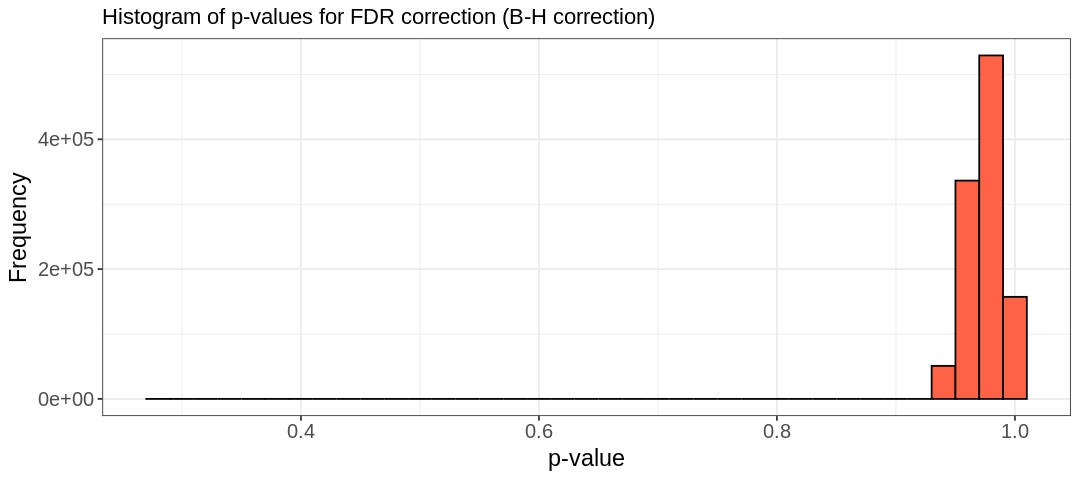

In [6]:
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

tests <- read.table("Results/GWAS5/adjusted_assoc_results.assoc.adjusted", header=T)

hist.relatedness <- ggplot(tests, aes(x=FDR_BH)) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of p-values for FDR correction (B-H correction)") + 
  xlab("p-value") + 
  ylab("Frequency") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), axis.text=element_text(size=12))

show(hist.relatedness)

# Write code here


:::{.callout-tip title="Solution"}

In R: `summary(tests$FDR_BH)`
- Min=0.29
- Mean=0.97

The black line indicates that there are very few values with an FDR-adjusted p-value lower than ~0.95, with the lowest being ~0.29 (corresponding to the Min. value printed in the summary table). Thus, in this particular case, we see that no single variant is significant at the 0.05 level after genome-wide correction.

:::

Finally, we can have a look at the permutation correction. Since this is a computationally intensive way of testing, we run it on a subset of the data including only chromosome 22. We will also need the option `--mperm` to define how many permutations we want to do.
The subset of the data is done below:

In [1]:
awk '{ if ($1 == 22) print $2 }' Results/GWAS4/HapMap_3_r3_10.bim > Results/GWAS5/subset_snp_chr_22.txt

plink --bfile Results/GWAS4/HapMap_3_r3_10 --extract Results/GWAS5/subset_snp_chr_22.txt --make-bed \
--out Results/GWAS5/HapMap_subset_for_perm --silent

Now we run permutation testing (we choose 100K permutations to avoid waiting too long)

In [9]:
plink --bfile Results/GWAS5/HapMap_subset_for_perm --assoc --mperm 1000000 --threads 4 \
--out Results/GWAS5/perm_result --silent

The table in output looks like this, with the `EMP2` column indicating the corrected p-value

In [10]:
head -5 Results/GWAS5/perm_result.assoc.mperm

 CHR          SNP         EMP1         EMP2 
  22   rs11089128      0.09869            1 
  22    rs7288972       0.3679            1 
  22   rs11167319       0.7516            1 
  22    rs8138488      0.01473            1 


:::{.callout-important title="Stop - Read - Solve"}
Are there any significant SNPs? 

:::

:::{.callout-tip title="Solution"}

:::

<img src="Images/R.png" alt="R" width="40"> Again, we do not infer any significance with the permutation correction.

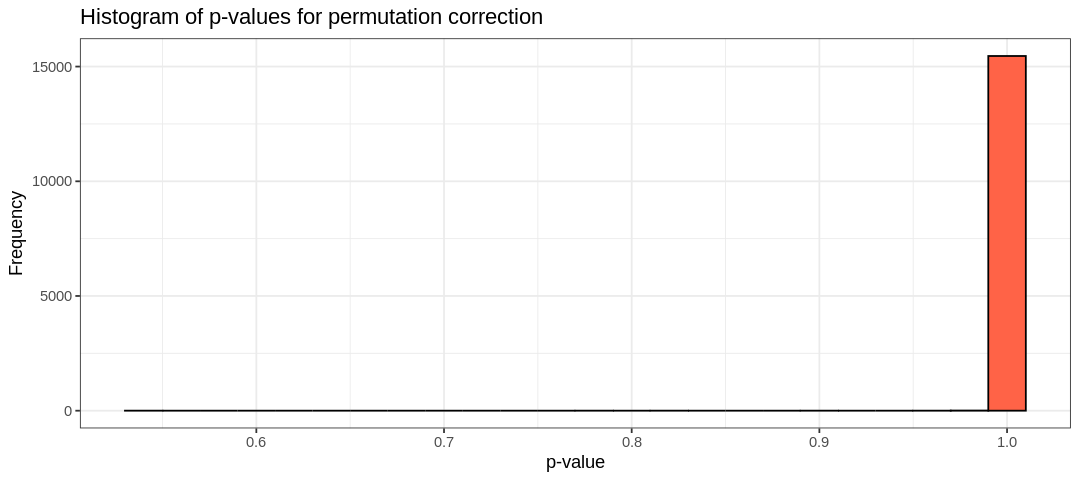

In [2]:
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

tests <- read.table("Results/GWAS5/perm_result.assoc.mperm", header=T)

hist.relatedness <- ggplot(tests, aes(x=EMP2)) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of p-values for permutation correction") + 
  xlab("p-value") + 
  ylab("Frequency") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), axis.text=element_text(size=12))


show(hist.relatedness)

All in all, when correcting for multiple testing, it is important to keep in mind that different correction measures have different properties, and it is up to the investigator to decide which to use and how to interpret them. In general, **permutation correction is considered to be the gold standard in GWAS analysis**, but it is not always effective when used with specific statistical models (@joo_multiple_2016 , @uffelmann_genome-wide_2021), a problematic you should be aware of.

### Manhattan and QQ-plots

<img src="Images/R.png" alt="R" width="40">

We can make suggestions for the presence of high-association alleles using a visual approach. The first is called a **Manhattan plot**. The idea is straightforward: for each SNP, we plot it against the negative log of its p-value from the test of association [@gibson2010hints]. We can generate these plots with the `R` package `qqman` using the `manhattan()` function.

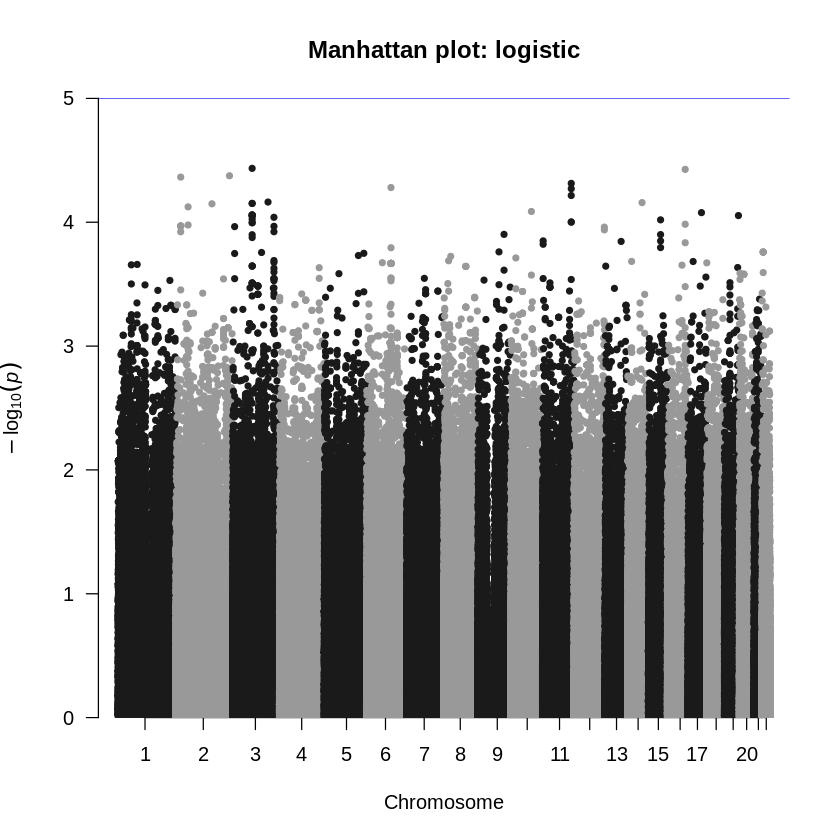

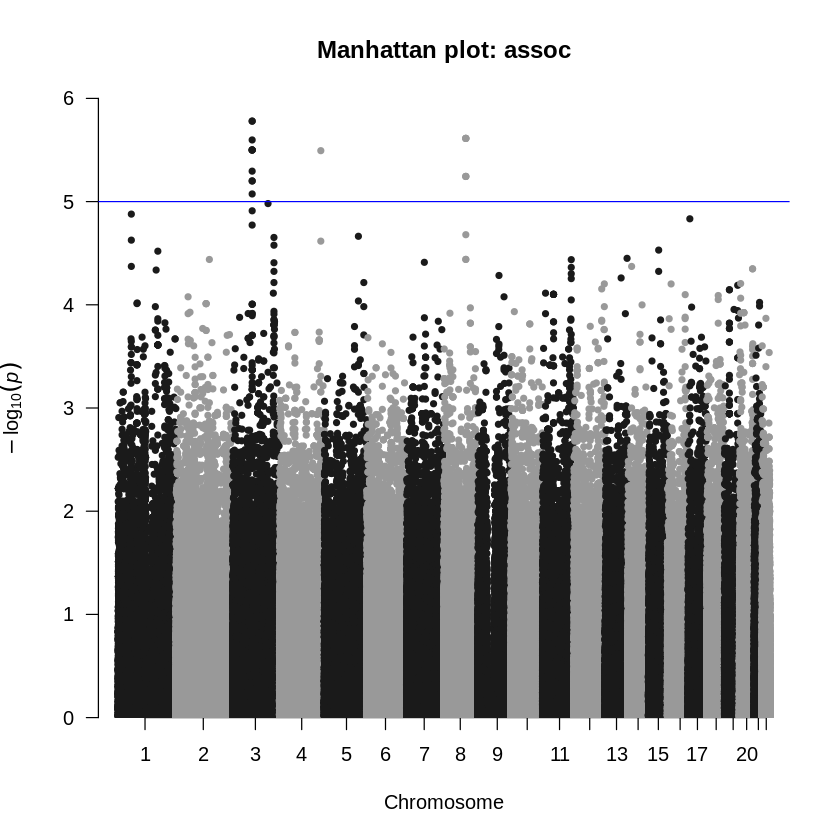

In [1]:
# Setup to avoid long messages and plot on screen
options(warn=-1)
options(jupyter.plot_mimetypes = 'image/png')

# Load GWAS package qqman
suppressMessages(library("qqman"))

# Manhattan plot using --logistic results
results_log <- read.table("Results/GWAS5/logistic_results.assoc_2.logistic", head=TRUE)
manhattan(results_log,chr="CHR",bp="BP",p="P",snp="SNP", main = "Manhattan plot: logistic")

# Manhattan plot using --assoc
results_as <- read.table("Results/GWAS5/assoc_results.assoc", head=TRUE)
manhattan(results_as,chr="CHR",bp="BP",p="P",snp="SNP", main = "Manhattan plot: assoc")  

:::{.callout-important title="Stop - Read - Solve"}

The blue line represents the threshold for significance (in the two plots, $10^{-5}$). We can see that there are no significant SNPs associated with the phenotype when we use the `--logistic` command (first plot). However, when we use the `--assoc` command (second plot), we obtain significant SNPs. 

Why is there a difference?

:::

:::{.callout-tip title="Solution" collapse="true"}

Recall from the beginning of this chapter that the `--assoc` command does not correct for covariates. So even though we have promising (and hopefully publishable!) results, this form of analysis may be flawed by the underlying population stratification, which is taken into account with the `--logistic` model. 

:::

The second method of visually determining significance is to use a [**QQ-plot**](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). This plots the expected $-\log_{10}p$ value against the observed $-\log_{10}p$ value. It's a good way to observe not only outliers that could have significant associations but also peculiarities within our data. For example, if a plot suggests an extreme deviation between the x- and y-axes, then there might be an error with our analyses or data. 

We will create these plots using the qq() function from the qqman package in R.

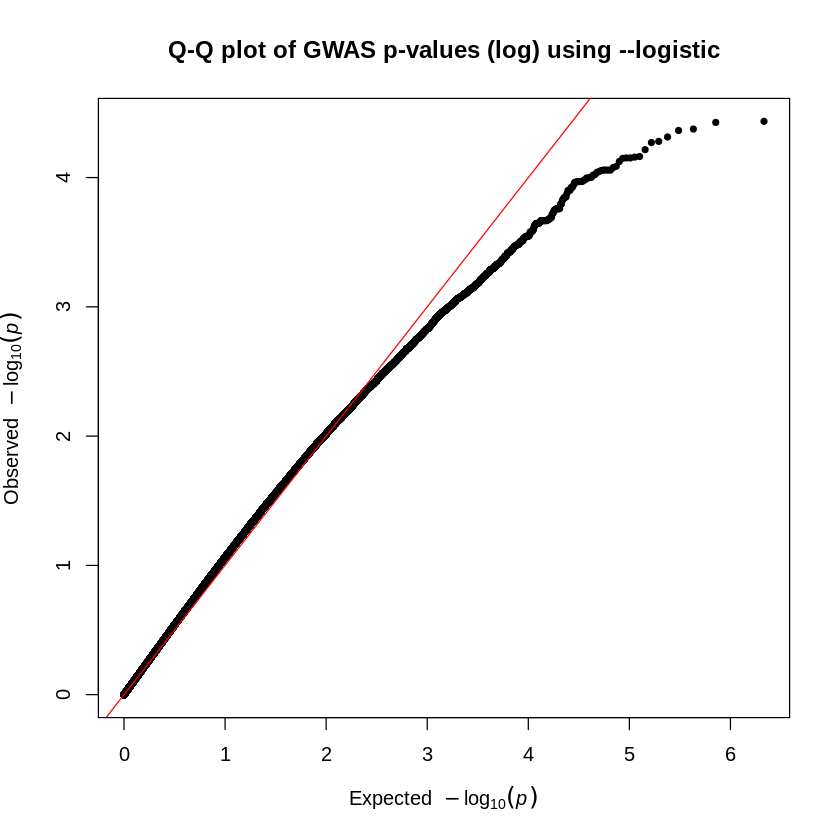

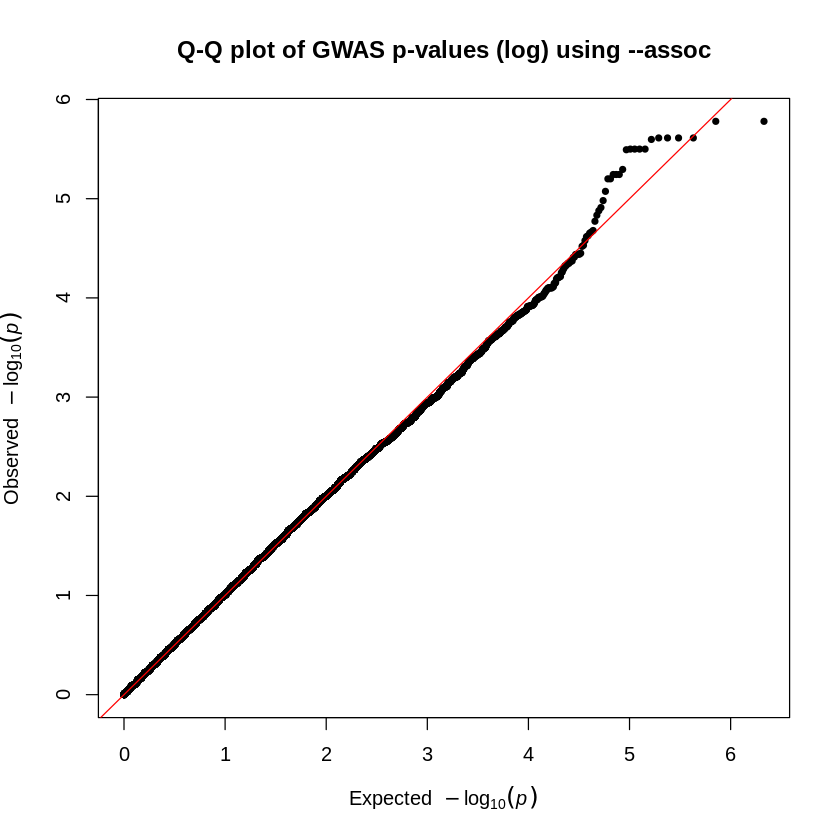

In [2]:
# Setup to avoid long messages and plot on screen
options(warn=-1)
options(jupyter.plot_mimetypes = 'image/png')

# Install and load GWAS package qqman
suppressMessages(library("qqman")) 

# QQ plot for --logistic
results_log <- read.table("Results/GWAS5/logistic_results.assoc_2.logistic", head=TRUE)
qq(results_log$P, main = "Q-Q plot of GWAS p-values (log) using --logistic")

# QQ plot for --assoc
results_as <- read.table("Results/GWAS5/assoc_results.assoc", head=TRUE)
qq(results_as$P, main = "Q-Q plot of GWAS p-values (log) using --assoc")

We can observe that in the upper half of the first plot (`--logistic`), the observed values are lower than the expected values. This pattern is consistent with what we see in the corresponding Manhattan plot. Additionally, examining the Q-Q plot generated from the `--assoc` command output reveals SNPs where the expected p-values exceed the observed p-values.

It's important to remember that, while this suggests an association between these SNPs and the studied phenotype, there isn't sufficient information here to determine the **causal variant**. In fact, there could potentially be multiple causal variants and the causal variants could be in LD with some of the significant variants. Identifying the causal variants would require further investigation using biological methods. However, this analysis has significantly reduced the number of SNPs that need to be studied.